<a href="https://colab.research.google.com/github/babymlin/Retina_78.7_percent/blob/main/transfer_learning_keras_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

     |████████████████████████████████| 686kB 9.6MB/s 


In [2]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

In [3]:
# download from google drive or upload file by yourself
!gdown --id '1ZrB69wSgzXLu8UZdPJb8hnB6K4eltcpu' --output retina-dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1ZrB69wSgzXLu8UZdPJb8hnB6K4eltcpu
To: /content/retina-dataset.zip
35.1MB [00:00, 68.2MB/s]


In [4]:
# unzip dataset file
!unzip -q retina-dataset.zip

#### Data Visualization

In [5]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

retina-train/3329_right_0.jpeg


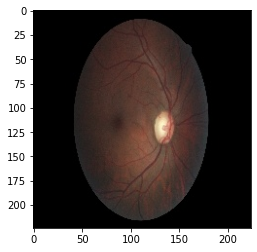

In [6]:
idx = np.random.randint(0, len(paths), size=1)[0]
path = paths[idx]
# path = 'retina-train/5258_right_2.jpeg'
img = cv2.imread(path)# [:,:,::-1]
plt.imshow(img[:,:,::-1])
print(path)

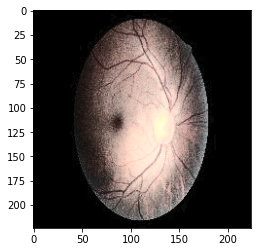

In [7]:
# Histogram Equalization
img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(img_y_cr_cb)

# Applying equalize Hist operation on Y channel.
y_eq = cv2.equalizeHist(y)
img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)
plt.imshow(img_rgb_eq)

In [8]:
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])

all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~4
print(all_cls[:3])

['34752_left_0.jpeg', '2966_left_1.jpeg', '27851_left_1.jpeg']
[0, 1, 1]


<BarContainer object of 3 artists>

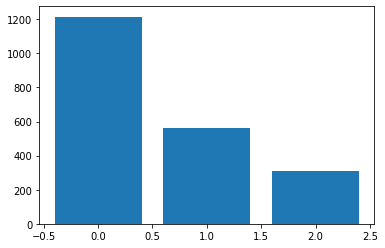

In [9]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Build Transfer Learning Model

In [10]:
# clear graph
tf.keras.backend.clear_session()

In [11]:
# Method 1: 

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(3)(x)
predictions = layers.Softmax()(x)

# Freeeze layers
for l in base_model.layers:
    l.trainable = False

model = models.Model(base_model.input, predictions)

16711680/16705208 [==============================] - 0s 0us/step


In [12]:
#model.summary()

#### Prepare Data

In [13]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        # preprocess by histogram equlization
        img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(img_y_cr_cb)
        # Applying equalize Hist operation on Y channel.
        y_eq = cv2.equalizeHist(y)
        img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
        img = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)

        # !!!!!!!!! Use model preprocessing function !!!!!!!!!!
        #img = tf.keras.applications.efficientnet.preprocess_input(img)
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes) # one-hot encoding
        return x_data, y_data
    else:
        return x_data

In [14]:
x_data, y_data = create_dataset(paths)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:00<00:00, 634.42it/s]


In [15]:
from tensorflow.keras.applications.efficientnet import preprocess_input
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=preprocess_input)
datagen.fit(x_data)

In [16]:
#x_train.shape, y_train.shape, x_val.shape, y_val.shape

#### Training

In [17]:
import os
model_dir = "retina"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
file_name = "retina-best-model"
modelfile = f"{model_dir}/{file_name}.h5"
logfile = f"{model_dir}/{file_name}_training.log"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
model_chpo = tf.keras.callbacks.ModelCheckpoint(modelfile, monitor='val_loss', save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1)
csv_logger = tf.keras.callbacks.CSVLogger(logfile)
callbacks_list = [model_chpo, earlystop, csv_logger]

In [18]:
radam = tfa.optimizers.RectifiedAdam(5e-4)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model.compile(optimizer=ranger, 
        loss=losses.categorical_crossentropy, 
        metrics=[metrics.categorical_accuracy])

In [19]:
logs = model.fit(datagen.flow(x_data, y_data, subset='training'),
          batch_size=32,
          epochs=50,
          validation_data=datagen.flow(x_data, y_data, subset='validation'),
          verbose=2,
          callbacks=callbacks_list)

Epoch 1/50
53/53 - 56s - loss: 1.0893 - categorical_accuracy: 0.3913 - val_loss: 1.0232 - val_categorical_accuracy: 0.5851


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
53/53 - 19s - loss: 0.9681 - categorical_accuracy: 0.5812 - val_loss: 0.9277 - val_categorical_accuracy: 0.5875
Epoch 3/50
53/53 - 19s - loss: 0.9049 - categorical_accuracy: 0.5818 - val_loss: 0.8744 - val_categorical_accuracy: 0.5899
Epoch 4/50
53/53 - 19s - loss: 0.8575 - categorical_accuracy: 0.6046 - val_loss: 0.8293 - val_categorical_accuracy: 0.6043
Epoch 5/50
53/53 - 19s - loss: 0.8220 - categorical_accuracy: 0.6315 - val_loss: 0.8036 - val_categorical_accuracy: 0.6547
Epoch 6/50
53/53 - 19s - loss: 0.7937 - categorical_accuracy: 0.6417 - val_loss: 0.7850 - val_categorical_accuracy: 0.6715
Epoch 7/50
53/53 - 19s - loss: 0.7776 - categorical_accuracy: 0.6429 - val_loss: 0.7778 - val_categorical_accuracy: 0.6523
Epoch 8/50
53/53 - 19s - loss: 0.7662 - categorical_accuracy: 0.6495 - val_loss: 0.7665 - val_categorical_accuracy: 0.6715
Epoch 9/50
53/53 - 19s - loss: 0.7476 - categorical_accuracy: 0.6567 - val_loss: 0.7613 - val_categorical_accuracy: 0.6643
Epoch 10/50
53/5

In [20]:
model_dir = 'retina'
file_name = "retina-best-model"
modelfile = f"{model_dir}/{file_name}.h5"
model = tf.keras.models.load_model(modelfile)
model.evaluate(datagen.flow(x_data, y_data, subset='validation'))

14/14 [==============================] - 5s 274ms/step - loss: 0.7366 - categorical_accuracy: 0.6691


[0.7366433143615723, 0.6690647602081299]

#### Make Submission file

Kaggle: https://www.kaggle.com/c/retinopathy-classification-sai/data


In [21]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,2
1,10031_right.jpeg,0
2,10150_left.jpeg,0
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,2
518,9673_right.jpeg,0
519,9690_left.jpeg,1
520,9717_right.jpeg,0
